In [148]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import tensorflow as tf
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [149]:
column_names = ['date','req', 'err', 'rmem', 'rcpu', 'rfs', 'dur', 'nett', 'nrr', 'cpu', 'mem', 'nmem', 'ncpu', 'dbops','dbconn']
df = pd.read_csv('raw_timeseries_data.csv', header=0, parse_dates=[0], index_col=0, skiprows=1, names=column_names)

# move target column (err) to the end 
cols = df.columns.tolist()
cols.insert(len(cols)-1, cols.pop(cols.index('err')))
df = df.reindex(columns= cols)

df.head()

,req,rmem,rcpu,rfs,dur,nett,nrr,cpu,mem,nmem,ncpu,dbops,dbconn,err
date,,,,,,,,,,,,,,
2018-03-27 23:45:00,0.03269,-0.000425,-0.253,0.260,0.02230,0.135367,0.000,0.0061,0.011172,0.007859,0.00573,-0.007616,0.0,0.0
2018-03-27 23:46:00,0.11168,-0.000425,0.739,0.260,0.04720,0.032426,0.000,0.0279,-0.003365,0.020557,0.00568,0.035800,0.0,0.0
2018-03-27 23:47:00,-0.08594,0.020050,-0.666,-0.260,-0.02545,-0.180513,-577647.545,-0.0253,0.000175,-0.043505,0.00341,0.035800,0.0,0.0
2018-03-27 23:48:00,-0.08594,0.020050,-0.666,-0.260,-0.02545,-0.180513,-577647.545,-0.0253,0.000175,-0.043505,0.00114,0.035800,0.0,0.0
2018-03-27 23:49:00,0.21049,0.026680,0.549,0.096,0.03770,0.926611,1288056.870,0.0284,0.111626,0.321375,0.00936,0.035800,0.0,0.0


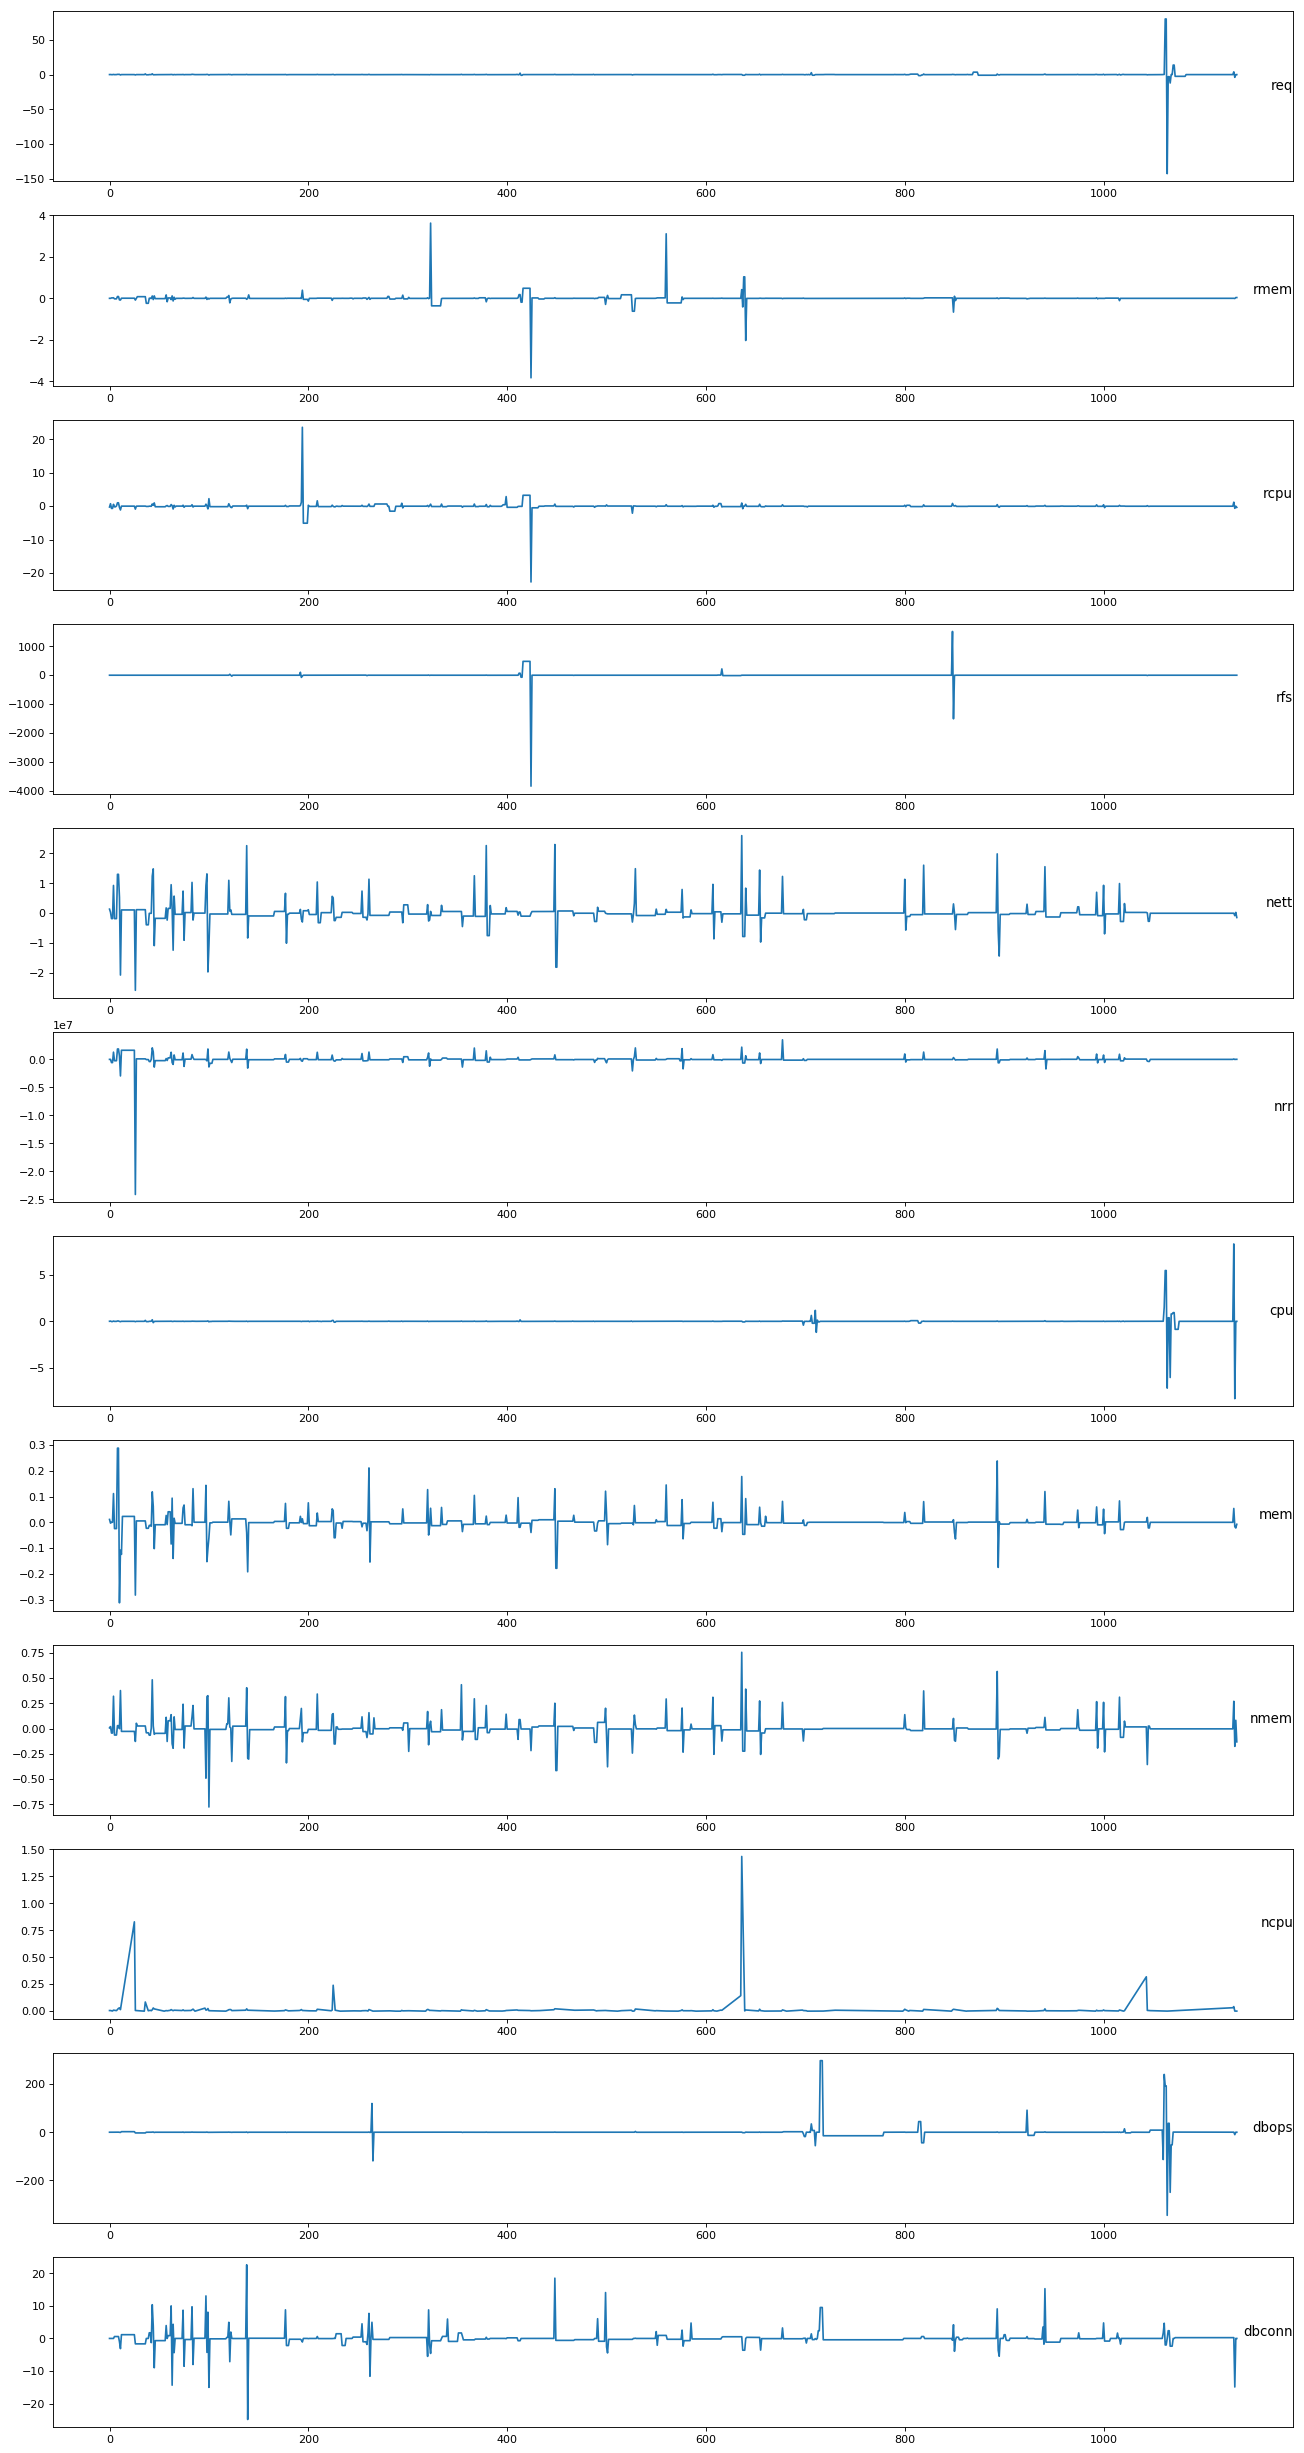

In [150]:
values = df.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12]
i = 1
# plot each column
plt.figure(figsize=(20, 40), dpi=80, facecolor='w', edgecolor='k')
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(df.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

## Multivariate LSTM Forecast Model

We need to create a forecasting model that can predict current set of metrics given past observed metrics. I will fit an LSTM model to the collected metrics data. First we need to transfer the time series dataset into a supervised learning dataset. I will use Pandas shift function to achieve this goal.

In [151]:
# convert series to supervised learning
def series_to_supervised(data, col_names, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
    data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        col_names: List of feature column names
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (col_names[j], i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % (col_names[j])) for j in range(n_vars)]
        else:
            names += [('%s(t+%d)' % (col_names[j], i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [152]:
# integer encode direction
#encoder = preprocessing.LabelEncoder()
#values[:,2] = encoder.fit_transform(values[:,2])   # error as target column to encode
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, column_names[1:], 1, 1)
# drop columns we don't want to predict
drop_columns = ['req(t)', 'rmem(t)', 'rcpu(t)', 'rfs(t)', 'dur(t)', 'nett(t)', 'nrr(t)', 'cpu(t)', 'mem(t)', 'nmem(t)', 'ncpu(t)', 'dbops(t)','dbconn(t)']
reframed.drop(drop_columns, axis=1, inplace=True)
reframed.head()

,req(t-1),err(t-1),rmem(t-1),rcpu(t-1),rfs(t-1),dur(t-1),nett(t-1),nrr(t-1),cpu(t-1),mem(t-1),nmem(t-1),ncpu(t-1),dbops(t-1),dbconn(t-1),err(t)
1,0.640444,0.513754,0.484479,0.717147,0.710879,0.524696,0.873522,0.500289,0.539034,0.511445,0.003994,0.537214,0.523951,0.0,0.513754
2,0.640799,0.513754,0.505908,0.717147,0.754221,0.504757,0.873522,0.501600,0.514829,0.519737,0.003960,0.537281,0.523951,0.0,0.516500
3,0.639911,0.516500,0.475558,0.717049,0.627763,0.463511,0.852609,0.498400,0.520723,0.477903,0.002377,0.537281,0.523951,0.0,0.516500
4,0.639911,0.516500,0.475558,0.717049,0.627763,0.463511,0.852609,0.498400,0.520723,0.477903,0.000795,0.537281,0.523951,0.0,0.517390
5,0.641243,0.517390,0.501804,0.717116,0.737685,0.677956,0.920153,0.501630,0.706292,0.716174,0.006525,0.537281,0.523951,0.0,0.510474


In [153]:
data = reframed.values

n_train = round(0.7 * data.shape[0])   # take 70% of sample for training
n_valid = round(0.1 * data.shape[0])   # 1% for validation &  2% for testing
train = data[:n_train, :]              
valid = data[n_train:n_train+n_valid, :]
test = data[n_train+n_valid:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
valid_X, valid_y = valid[:, :-1], valid[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
valid_X = valid_X.reshape((valid_X.shape[0], 1, valid_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape, valid_X.shape, valid_y.shape)

(794, 1, 14) (794,) (227, 1, 14) (227,) (113, 1, 14) (113,)


## Create and Train Model

Next, define and fit an LSTM model.

I will define the LSTM with 50 neurons in the first hidden layer and 1 neuron in the output layer for predicting pollution. 
The input shape will be 1 time step with 14 features.

In [154]:
epochs = 100
batch = 50

# design network
model = Sequential()
model.add(LSTM(100
               ,return_sequences=True
               , input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(75
               ,return_sequences=True))
model.add(LSTM(50
               ,return_sequences=True))
model.add(LSTM(25
               ,return_sequences=True))
model.add(LSTM(10
               ))
model.add(Dense(1))
#model.compile(loss='mae', optimizer='adam')
model.compile(loss='mean_squared_error', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch
                    , validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 794 samples, validate on 227 samples
Epoch 1/100
 - 4s - loss: 0.2477 - val_loss: 0.2236
Epoch 2/100
 - 0s - loss: 0.1878 - val_loss: 0.1200
Epoch 3/100
 - 0s - loss: 0.0416 - val_loss: 0.0121
Epoch 4/100
 - 0s - loss: 0.0062 - val_loss: 0.0013
Epoch 5/100
 - 0s - loss: 0.0022 - val_loss: 1.5807e-05
Epoch 6/100
 - 0s - loss: 0.0013 - val_loss: 2.2301e-05
Epoch 7/100
 - 0s - loss: 0.0012 - val_loss: 2.4047e-05
Epoch 8/100
 - 0s - loss: 0.0012 - val_loss: 1.5307e-05
Epoch 9/100
 - 0s - loss: 0.0012 - val_loss: 1.5325e-05
Epoch 10/100
 - 0s - loss: 0.0012 - val_loss: 1.4051e-05
Epoch 11/100
 - 0s - loss: 0.0012 - val_loss: 1.4270e-05
Epoch 12/100
 - 0s - loss: 0.0012 - val_loss: 1.4053e-05
Epoch 13/100
 - 0s - loss: 0.0012 - val_loss: 1.4037e-05
Epoch 14/100
 - 0s - loss: 0.0012 - val_loss: 1.3957e-05
Epoch 15/100
 - 0s - loss: 0.0012 - val_loss: 1.3888e-05
Epoch 16/100
 - 0s - loss: 0.0012 - val_loss: 1.3819e-05
Epoch 17/100
 - 0s - loss: 0.0012 - val_loss: 1.3744e-05
Epoch 18/1

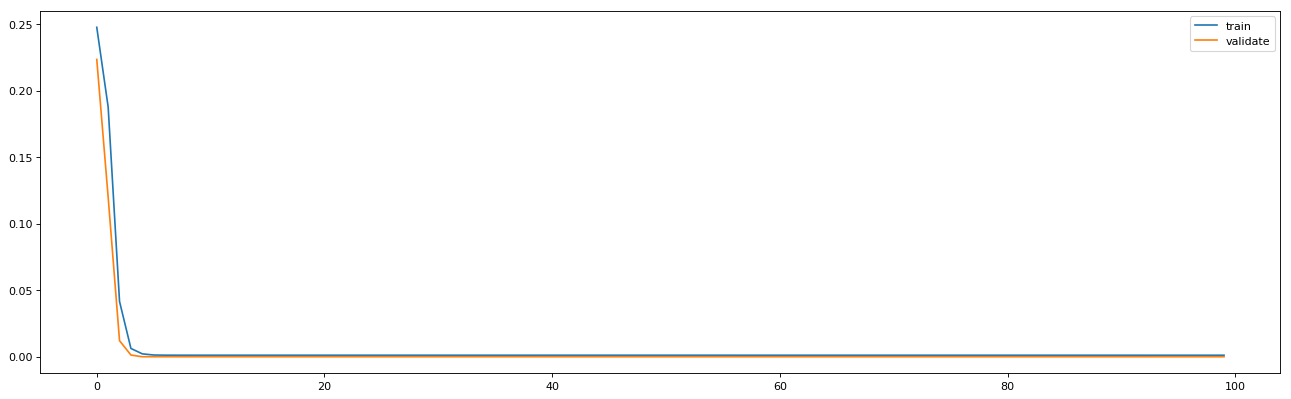

In [155]:
# plot history
plt.figure(figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validate')
plt.legend()
plt.show()

## Evaluate Model

In [156]:
import math

# make a prediction
yhat = model.predict(valid_X)
valid_X = valid_X.reshape((valid_X.shape[0], valid_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((valid_X[:, :-1], yhat), axis=1)


inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]
inv_yhat = inv_yhat.flatten()
inv_yhat = [math.floor(i) for i in inv_yhat]

print ("Predicted values: {}".format(inv_yhat[:20]))

# invert scaling for actual
valid_y = valid_y.reshape((len(valid_y), 1))
inv_y = np.concatenate((valid_X[:, :-1], valid_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]
inv_y = inv_y.flatten()
inv_y = [math.floor(i) for i in inv_y]

print ("Actual values: {}".format(inv_y[:20]))
# calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Predicted values: [87, 87, 87, 87, 87, 87, 88, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87]
Actual values: [87, 87, 87, 87, 87, 88, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87]
Test RMSE: 1.678


In [160]:
# df['f'] = df['d'].rolling(2).sum().shift(-1)

compare_df = pd.DataFrame({'actual':inv_y, 'predicted':inv_yhat})
compare_df = compare_df.dropna(axis=0, how='all')
# referse the diff (stationary)
compare_df['actual'] = compare_df['actual'].rolling(2).sum().shift(-1)
compare_df['predicted'] = compare_df['predicted'].rolling(2).sum().shift(-1)

not_matching = compare_df.loc[compare_df.actual != compare_df.predicted]
matching = compare_df.loc[compare_df.actual == compare_df.predicted]

bad_ones = not_matching.shape[0]
all_sample = compare_df.shape[0]

print("Out of {} there are {} not matching!".format(all_sample, bad_ones))

matching.head()

Out of 113 there are 49 not matching!


,actual,predicted
0,174.0,174.0
1,174.0,174.0
2,174.0,174.0
3,174.0,174.0
5,175.0,175.0


In [147]:
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score

compare_df = compare_df.dropna(axis=0, how='all')
actuals = compare_df['actual']
predicted = compare_df['predicted']
actuals = actuals.values
predicted = predicted.values

#actuals
r2 = r2_score(actuals, predicted)
variance = explained_variance_score(actuals, predicted)

print("R2 = {}".format(r2))
print("Explained variance: {}".format(variance))

R2 = -0.18996307738678309
Explained variance: -0.1465601687890885
